# Imports

In [212]:
# Data Manipulation
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Visualisations
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Cell output display -- all
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# Ignore exceptions
import expectexception

# Cleaning

In [13]:
train_tr = pd.read_csv('./data/train_transaction.csv')
train_id = pd.read_csv('./data/train_identity.csv')
test_tr = pd.read_csv('./data/test_transaction.csv')
test_id = pd.read_csv('./data/test_identity.csv')

In [14]:
tr_raw = pd.merge(train_tr, train_id, how='left')
id_raw = pd.merge(test_tr, test_id, how='left')

In [15]:
# train_tr_copy = train_tr.drop('isFraud', axis=1)
# tr_raw = pd.concat([train_tr_copy, test_tr], sort=False)
# id_raw = pd.concat([train_id, test_id], sort=False)

In [16]:
train_tr.shape  ## (590540, 394)
train_id.shape  ## (144233, 41)

(590540, 394)

(144233, 41)

In [17]:
### Categorical columns as noted by Vesta
def paste0(string, start, end):
    return list(map(lambda x: ''.join(x), zip([string]*(end - start + 1), map(str, range(start, end + 1)))))

cards = paste0('card', 1, 6)
Ms = paste0('M', 1, 9)
ids = paste0('id_', 12, 38)

cat_tr = ['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + cards + Ms
cat_id = ['DeviceType', 'DeviceInfo'] + ids
cats = cat_tr + cat_id

# Fraud Aggregations

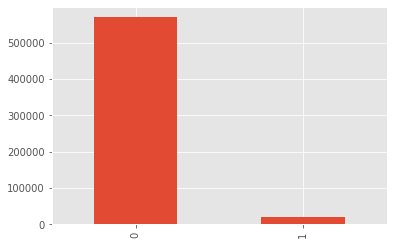

In [18]:
tr_raw['isFraud'].value_counts().plot.bar()

## Functions

In [19]:
### function to check for outlying fraud values in columns
### can be modified to identify individual values, such as 'protonmail.com'
### returns a list of columns to EDA
def outlying_fraud(in_df, cols, threshold=0.85):
    record = []
    for col in cols:
        uniques = in_df[col].unique()
        
        for uni in uniques:
            all = in_df[in_df[col] == uni]['isFraud']
            percent_fraud = all.sum()/all.shape[0]
            
            if percent_fraud > threshold:
#                 print('{} has {} fraud for value {}'.format(col, percent_fraud, uni))
                record.append(col)
                print(col)
                break        
    return record

### function to graph outlying fraud values in identified columns
def graph_freq(feature, count):
    grouped = tr_raw.groupby(feature)['isFraud'].agg({'fraud':'sum','total':'count'})
    freq = grouped.fraud/grouped.total
    freq = freq.nlargest(count)
    return freq.plot.bar()

### function to count high-outlying values in pre-identified columns
def outlying_matrix(in_df, cols):
    matrix = {}
    for col in cols:
        grouped = in_df.groupby(col)['isFraud'].agg({'fraud':'sum','total':'count'})
        freq = grouped.fraud/grouped.total
        matrix[col] = freq[freq > 0.9].count()
    return matrix

### number of unique values in select columns
def nunique_sel(in_df, cols):
    matrix = {}
    for col in cols:
        matrix[col] = in_df[col].nunique()        
    return matrix

### divide two dictionaries via key
def divide(num, denom):
    return {key: num[key] / denom[key] for key in denom if key in num}

#######

from pandas.api.types import is_string_dtype

### extract string columns for encoding
def str_cols(in_df):
    df = in_df.copy()
    return [col for col in df.columns if is_string_dtype(df[col])]

## General Multivariates

In [20]:
### general multivariates
raw_corr = tr_raw.corr()
tr_raw.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,421571.000000,421571.000000,421571.000000,421571.00000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,590226.000000,590226.00000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.0000

In [21]:
raw_corr.iloc[1:2, :]

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
isFraud,0.014166,1.0,0.013103,0.01132,-0.01364,0.003388,0.154151,-0.03358,0.005596,-0.030387,0.021522,-0.019054,0.03057,0.037229,-0.006833,0.030382,-0.030754,0.020909,0.02816,0.032139,-0.031703,0.028396,0.027484,0.031905,-0.011146,0.007921,-0.067193,-0.083583,-0.046271,-0.067216,-0.064638,-0.057236,-0.127199,-0.142636,-0.044253,-0.072002,-0.045094,-0.028864,-0.05943,-0.008663,-0.077519,0.001045,0.019872,0.049257,0.012611,0.036904,0.010552,0.023492,0.016041,0.037915,-0.074658,-0.07195,-0.052406,-0.045706,0.002145,0.177963,0.174318,0.182673,0.18255,0.030904,0.040341,0.165985,0.158814,0.149408,0.123824,0.003826,0.015929,-0.004979,-0.004895,-0.107852,-0.103088,0.163166,0.160197,0.183486,0.180301,-0.077116,-0.069875,0.176947,0.199005,0.203097,0.212442,0.004154,0.189428,0.198274,0.260376,0.281832,0.125991,0.164114,-0.115786,-0.11092,0.179953,0.223191,0.239469,-0.0474,-0.037025,0.050114,0.061356,0.168887,0.173065,0.151062,0.150952,0.049412,0.072399,0.153353,0.150371,0.002701,0.037631,0.076194,-0.004048,-0.104521,-0.1009,0.15684,0.160951,0.17387,0.185915,-0.052171,-0.046419,0.158381,0.150425,0.194141,0.180299,0.182377,0.051115,0.069155,0.16911,0.16884,0.251828,0.251737,0.000554,-0.005188,-0.110168,-0.105453,0.180513,0.180983,0.188407,-0.00412,-0.005484,-0.004491,0.027318,-0.013179,0.011286,-0.004712,-0.004848,-0.005121,0.003485,-0.003229,-0.002091,0.002554,0.096794,0.060994,0.08163,0.12161,0.105212,0.115976,0.096086,0.057108,0.080644,0.049439,0.040601,0.048135,0.019678,0.01233,0.018712,0.138222,0.076721,0.111999,-0.003546,-0.002629,-0.00193,0.012731,0.003076,0.024975,-0.004263,-0.003165,-0.003512,-0.000276,-0.000042,-0.000115,0.042658,0.147594,0.196938,0.085628,0.080411,-0.029767,-0.05197,-0.061964,0.198584,0.242894,0.228891,0.273282,-0.063965,-0.060868,-0.059154,0.183114,0.206958,0.234199,0.275952,0.234866,0.278066,-0.06266,-0.062338,0.039806,0.053302,0.046532,-0.027445,-0.051399,-0.029436,-0.012854,-0.016021,0.068103,0.249794,0.216508,-0.013237,-0.021349,0.016204,-0.002222,0.164343,-0.013715,-0.016543,-0.015904,-0.009339,0.028337,-0.010108,-0.0006

## String Categoricals

In [201]:
### string columns that want strategic encoding
string_columns = str_cols(tr_raw)
mask = tr_raw[string_columns].nunique()
for_target_encoding = mask[(mask > 10)]
for_label_encoding = mask[(mask < 3)]
for_one_hot_encoding = mask[(mask > 2) & (mask < 10)]

In [211]:
strcol_uniques = list(for_label_encoding.values) + list(for_one_hot_encoding.values) + list(for_target_encoding.values)
strcol_index = list(for_label_encoding.index) + list(for_one_hot_encoding.index) + list(for_target_encoding.index)
color = ['red'] * len(for_label_encoding) + ['green'] * len(for_one_hot_encoding) + ['purple'] * len(for_target_encoding)

data = go.Bar(x=strcol_index, y=strcol_uniques, marker_color=color)
layout = go.Layout(
    title = "Number of Unique Values per String Categorical"
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

/Users/jng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




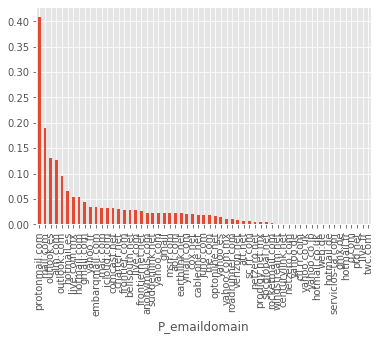

In [64]:
# for i in range(len(bears_investigation)):
#     col = bears_investigation.index[i]
#     count = bears_investigation.values[i]
#     graph_freq(col, count)

### these graphs provide a sanity check for our demarcation
### of low/med/hi-risk binning for later encoding
graph_freq('P_emaildomain', 59)

/Users/jng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




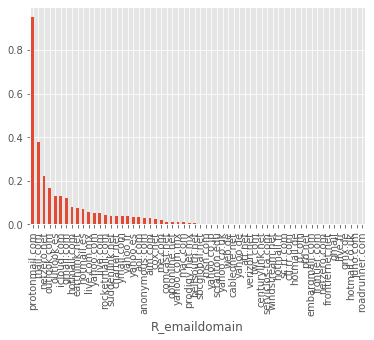

In [65]:
graph_freq('R_emaildomain', 60)

/Users/jng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




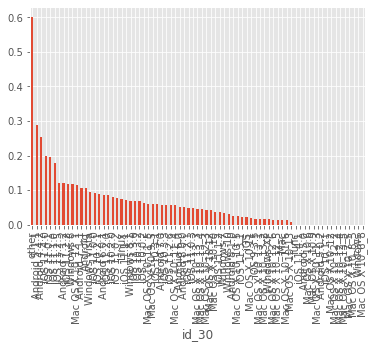

In [66]:
graph_freq('id_30', 75)

/Users/jng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




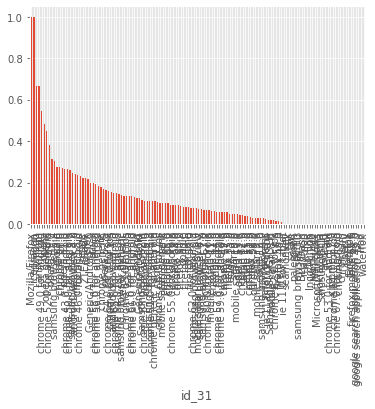

In [67]:
graph_freq('id_31', 130)

/Users/jng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




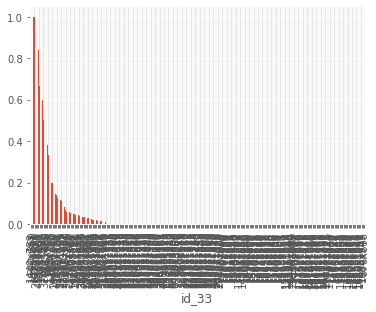

In [68]:
graph_freq('id_33', 260)
### id_33 is screen resolution and
### should be converted to pixel count

/Users/jng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




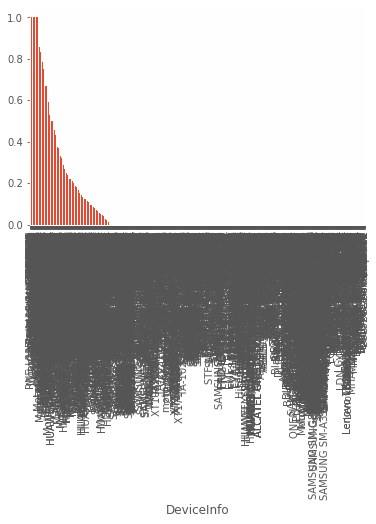

In [69]:
graph_freq('DeviceInfo', 1786)

## Outlying Value Aggregates

In [213]:
all_outliers = outlying_fraud(tr_raw, tr_raw.columns)

In [51]:
outliers = outlying_matrix(tr_raw, all_outliers)
nuniques = nunique_sel(tr_raw, all_outliers)
percent_fraud = divide(outliers, nuniques)

/Users/jng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




In [76]:
del outliers['TransactionID']
del outliers['isFraud']
del outliers['TransactionDT']
del percent_fraud['TransactionID']
del percent_fraud['isFraud']
del percent_fraud['TransactionDT']

In [119]:
outlying_values_in = pd.DataFrame([len(outliers), tr_raw.shape[1]])
outlying_values_in = outlying_values_in.set_index(pd.Index(['High-Flying Features', 'Total Features']))
outlying_values_in.columns = ['# Features']

labels = ['Notable Features', 'Others']
values = [len(outliers), tr_raw.shape[1] - len(outliers)]
fig = {
    'data': [
        {
            'labels': labels,
            'values': values,
            'name': '',
            'type': 'pie',
            'domain': {'x': [.2, 1]},
            'hoverinfo':'name+value',
        },
    ],
    'layout': {'title': 'Proportion of Features with Highly Fraudulent Values'}}

iplot(fig)

### we want a more finely-tuned picture of feature composition
### moreso than this majority split

In [77]:
### let's pick up 1) outliers with high repeats/low percentages, as fraudsters  
### are like to see reason to track that variable and 2) secondly, outliers 
### with high percentages of fraud in a reasonably sized pool of values

pd_outliers = pd.Series(outliers)
outliers_df = pd.DataFrame(pd_outliers)
outliers_df.columns = ['rawCount']

pd_percent_fraud = pd.Series(percent_fraud).round(decimals=4)
percent_fraud_df = pd.DataFrame(pd_percent_fraud)
percent_fraud_df.columns = ['incidenceRate']

outlying_fraud = ouliers_df.merge(percent_fraud_df, right_index=True, left_index=True)
row_ids = list(outlying_fraud[outlying_fraud['rawCount'] == 0]['rawCount'].index)
outlying_fraud['rawCount'][row_ids] = 1
outlying_fraud.head()

/Users/jng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,rawCount,incidenceRate
TransactionAmt,346,0.0166
card1,205,0.0151
card3,8,0.0702
card5,1,0.0084
addr2,6,0.0811


In [83]:
outlying_fraud['magnitude'] = np.floor(np.log10(outlying_fraud['rawCount'])) + 1
outlying_fraud.groupby('magnitude').describe()

rawCount                                                                    incidenceRate                                                                 
             count         mean          std     min     25%     50%      75%     max         count      mean       std     min       25%      50%       75%     max
magnitude                                                                                                                                                           
1.0           94.0     3.414894     2.407022     1.0     1.0     3.0     5.00     9.0          94.0  0.167901  0.150965  0.0000  0.035525  0.14290  0.259900  0.6250
2.0           81.0    31.654321    24.744777    10.0    15.0    20.0    40.00    99.0          81.0  0.320958  0.314475  0.0029  0.032300  0.20690  0.612900  0.8800
3.0           36.0   260.694444   221.261942   101.0   143.0   177.0   261.75   993.0          36.0  0.058250  0.040024  0.0121  0.029075  0.03955  0.099925  0.1396
4.0           21.0  2191.857143  1443.280475  1017.0  1305.0  2177.0  2474.00  7918.0          21.0  0.171771  0.093215  0.0438  0.082600  0.17410  0.245300  0.3206

In [168]:
mag_values = outlying_fraud.groupby('magnitude').count()['rawCount']
binrate = list(outlying_fraud.groupby('binnedRates').count()['rawCount'].values)

labels = ['10^4 values, 21 features', '10^3 values, 36 features', 
          '10^2 values, 81 features', '10^1 values, 94 features']
values = [21, 36, 81, 94]
fig = {
    'data': [
        {
            'labels': labels,
            'values': values,
            'name': '',
            'type': 'pie',
            'hoverinfo':'name+value',
        },
    ],
    'layout': {'title': '232 Notable Features Aggregated by Hi-Risk Value Counts'}}

iplot(fig)

In [171]:
abs_count_outliers = outlying_fraud[outlying_fraud['rawCount'] > 500]
values = abs_count_outliers['rawCount']
labels = abs_count_outliers.index

data = go.Bar(x=labels, y=values, marker_color='purple')
layout = go.Layout(
    title = "Highly Fraudulent Counts Per Feature"
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

###

values = abs_count_outliers['incidenceRate'].apply(lambda x: x*100)
labels = abs_count_outliers.index

data = go.Bar(x=labels, y=values, marker_color='purple')
layout = go.Layout(
    title = "Percentages of Total Feature")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [97]:
bins = [-1, .25, .50, .75, 1]
labels = [1, 2, 3, 4]
outlying_fraud['binnedRates'] = pd.cut(outlying_fraud['incidenceRate'], bins=bins, labels=labels)
outlying_fraud.head()

,rawCount,incidenceRate,magnitude,binnedRates
TransactionAmt,346,0.0166,3.0,1
card1,205,0.0151,3.0,1
card3,8,0.0702,1.0,1
card5,1,0.0084,1.0,1
addr2,6,0.0811,1.0,1


In [181]:
relative_count_outliers = outlying_fraud[outlying_fraud['binnedRates'] > 2]
values = relative_count_outliers['rawCount']
labels = relative_count_outliers.index

values = relative_count_outliers['incidenceRate'].apply(lambda x: x*100)
labels = relative_count_outliers.index

data = go.Bar(x=labels, y=values, marker_color='green')
layout = go.Layout(
    title = "Highly Fraudulent Percentages of Total Feature")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

###

values = relative_count_outliers['rawCount']
labels = relative_count_outliers.index

data = go.Bar(x=labels, y=values, marker_color='green')
layout = go.Layout(
    title = "Counts Per Feature"
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

/Users/jng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




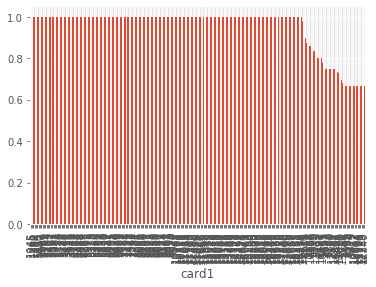

In [73]:
graph_freq('card1', 250)


grouped = tr_raw.groupby('card1')['isFraud'].agg({'fraud':'sum','total':'count'})
freq = grouped.fraud/grouped.total
freq = freq.nlargest(250)

data = go.Bar(x=['High-Flying Features', 'Total Features'], y=outlying_values_in['# Features'])
layout = go.Layout(
    title = "Proportion of Features with Highly Fraudulent Values"
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)


In [ ]:
graph_freq('addr2', 10)
graph_freq('card1', 250)
graph_freq('card3', 10)
graph_freq('card5', 10)
graph_freq('id_13', 10)
graph_freq('id_14', 10)
graph_freq('id_17', 10)
graph_freq('id_19', 10)
graph_freq('id_20', 20)
graph_freq('id_21', 20)
graph_freq('id_22', 10)
graph_freq('id_24', 10)
graph_freq('id_25', 20)
graph_freq('id_26', 10)

# Time Conversions

In [75]:
tr_raw['weekday'] = np.floor((tr_raw['TransactionDT'] / (3600 * 24) - 1) % 7)
tr_raw['hour'] = np.floor(tr_raw['TransactionDT'] / 3600) % 24

In [85]:
tr_raw.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,weekday,hour
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,

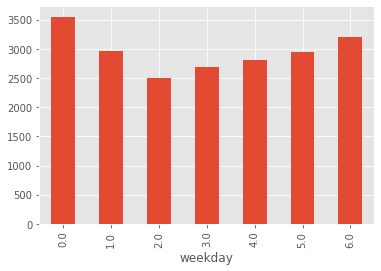

In [90]:
tr_raw.groupby('weekday')['isFraud'].sum().plot.bar()

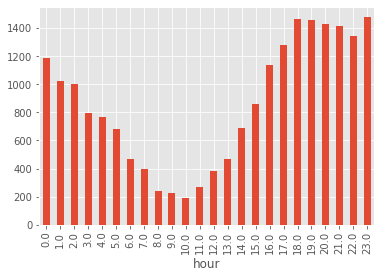

In [91]:
tr_raw.groupby('hour')['isFraud'].sum().plot.bar()

# Null Patterns

In [21]:
from pandas.api.types import is_numeric_dtype

### find numeric columns
def numerics(in_df, dtype):
    df = in_df.copy()
    return [col for col in df.columns if is_numeric_dtype(df[col])]

### identify cols with null values
def nulls(in_df):
    df = in_df.copy()
    return df.loc[:, df.isnull().any()].columns
        
### plot null frequencies across columns
def nullplot(in_df):
    return (in_df.isnull().sum()/len(in_df)).plot(kind='bar', figsize=(30,8)).set(ylabel='frequency NA', xlabel='var')

### check for consistency of null groups
def null_groupby_check(in_df):
    rule_breaker = []
    ncount = np.sum(tr_raw.isnull())
    null_groups = list(ncount.groupby(ncount))
    for i in range(len(null_groups)):
        null_subset = null_groups[i][1]
        if in_df.loc[in_df[null_subset.index[0]].isnull()][null_subset.index].isnull().values.all() == 1:
            print('null_group {} did not break the rules.'.format(i))
        else:
            rule_breaker.append(null_subset)
    return rule_breaker

[Text(0, 0.5, 'frequency NA'), Text(0.5, 0, 'var')]

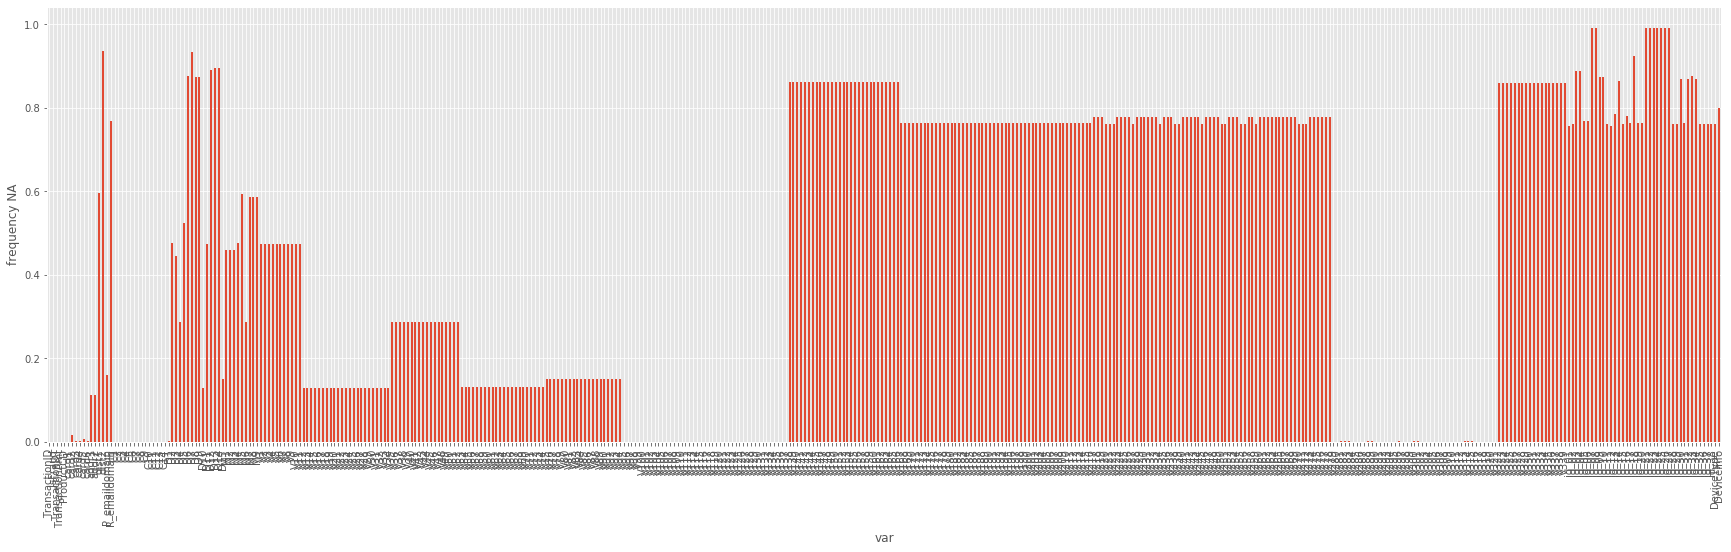

In [22]:
nullplot(tr_raw)

In [23]:
null_groupby_check(tr_raw)
### No rule breaks --- pattern holds.

null_group 0 did not break the rules.
null_group 1 did not break the rules.
null_group 2 did not break the rules.
null_group 3 did not break the rules.
null_group 4 did not break the rules.
null_group 5 did not break the rules.
null_group 6 did not break the rules.
null_group 7 did not break the rules.
null_group 8 did not break the rules.
null_group 9 did not break the rules.
null_group 10 did not break the rules.
null_group 11 did not break the rules.
null_group 12 did not break the rules.
null_group 13 did not break the rules.
null_group 14 did not break the rules.
null_group 15 did not break the rules.
null_group 16 did not break the rules.
null_group 17 did not break the rules.
null_group 18 did not break the rules.
null_group 19 did not break the rules.
null_group 20 did not break the rules.
null_group 21 did not break the rules.
null_group 22 did not break the rules.
null_group 23 did not break the rules.
null_group 24 did not break the rules.
null_group 25 did not break the rul

[]

# Refuse

In [ ]:
# # ## attempt to identify numeric categoricals
# def catnumerics(in_df):
#     numcol = numerics(in_df)
#     catnum = []
    
#     for col in numcol:
# #         if (in_df[col].nunique() > 100) and (in_df[col].nunique() < 180):
#             print('{} is a catnumeric with {} unique values'.format(col, in_df[col].nunique()))

# #             print('{} is a catnumeric with {} unique values of {}'.format(col, in_df[col].nunique(), sorted(in_df[col].unique())))
#             catnum.append(col)
            
#     print('{} columns'.format(len(catnum)))
#     return catnum

# def test_catnum(in_df):
#     catnum = catnumerics(in_df)
#     for col in catnum:
# #         count = in_df[col].value_counts().sort_index().to_frame().reset_index().plot.bar()
#         print(in_df[col].value_counts().sort_index())

In [ ]:
# high_counts = outlying_fraud[outlying_fraud['rawCount'] > 500]
# high_percentages = outlying_fraud[outlying_fraud['binnedRates'] > 2]

# upper_high_count = int(high_counts[high_counts['incidenceRate'] > .15]['rawCount'].mean())
# upper_high_percent = np.round(high_counts[high_counts['incidenceRate'] > .15]['incidenceRate'].mean() * 100, 1)
# lower_high_count = int(high_counts[high_counts['incidenceRate'] < .15]['rawCount'].mean())
# lower_high_percent = np.round(high_counts[high_counts['incidenceRate'] < .15]['incidenceRate'].mean() * 100, 1)

# counts = [upper_high_count, lower_high_count]
# percents = [upper_high_percent, lower_high_percent]